## Image-Based Hate Speech Detection Model

### Authors

- Sai Shishir Ailneni
- Priyaanka Reddy Boothkuri
- Manogna Tummanepally

## Introduction

In this notebook, we develop a model to detect hate speech using only the image data from memes. We employ a Convolutional Neural Network (CNN), a class of deep neural networks most commonly applied to analyzing visual imagery. Our goal is to build a model capable of classifying images as either containing hate speech or not, based solely on visual content.

## Import Required Libraries¶
Here, we import all necessary libraries that will be used throughout the notebook.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Input
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score,roc_auc_score,roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

np.random.seed(9012023)

## Data Loading and Preprocessing

The dataset consists of memes which are represented through their text content and images. Here, we load the dataset, create file paths for the images, and split the data into training and test sets.

In [2]:
data = pd.read_json('./data/train.jsonl', lines=True)

In [3]:
data.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [4]:
df = data[['label', 'img']]

In [5]:
df.head()

,label,img
0,0,img/42953.png
1,0,img/23058.png
2,0,img/13894.png
3,0,img/37408.png
4,0,img/82403.png


In [6]:
df['img'] = './data/' + df['img']

C:\Users\navee\AppData\Local\Temp\ipykernel_12208\889627064.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['img'] = './data/' + df['img']


In [7]:
# Split the dataframe df into train and test using train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Extract image paths and labels from the split DataFrames
train_image_paths = train_df['img'].tolist()
train_labels = train_df['label'].tolist()

test_image_paths = test_df['img'].tolist()
test_labels = test_df['label'].tolist()

## Image Preprocessing

Here, we define functions to load and preprocess images. This includes resizing the images and normalizing their pixel values.

In [8]:
# Define a function to load and preprocess images and convert them to numpy arrays
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Assuming images are in RGB format
    image = tf.image.resize(image, [64, 64])  # Specify desired height and width
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image.numpy(), label


In [9]:
# Load and preprocess images for training and testing sets and convert them to numpy arrays
x_train, y_train = [], []
for image_path, label in zip(train_image_paths, train_labels):
    image, label = load_and_preprocess_image(image_path, label)
    x_train.append(image)
    y_train.append(label)

x_train = np.array(x_train)
y_train = np.array(y_train)

x_test, y_test = [], []
for image_path, label in zip(test_image_paths, test_labels):
    image, label = load_and_preprocess_image(image_path, label)
    x_test.append(image)
    y_test.append(label)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [10]:
print(x_train.shape)

(6800, 64, 64, 3)


In [11]:
print(x_test.shape)
print(y_test.shape)

(1700, 64, 64, 3)
(1700,)


## CNN Model Construction

We build a CNN model with multiple convolutional and pooling layers, followed by dense layers for classification.

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # For binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

C:\Users\navee\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,833 (2.48 MB)

 Trainable params: 648,833 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

Now, we train the model using the processed image data.

In [13]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 37s 146ms/step - accuracy: 0.6390 - loss: 0.6650 - val_accuracy: 0.6324 - val_loss: 0.6476
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 37s 125ms/step - accuracy: 0.6504 - loss: 0.6425 - val_accuracy: 0.6324 - val_loss: 0.6457
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 40s 120ms/step - accuracy: 0.6445 - loss: 0.6376 - val_accuracy: 0.6324 - val_loss: 0.6404
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 40s 114ms/step - accuracy: 0.6446 - loss: 0.6268 - val_accuracy: 0.6382 - val_loss: 0.6350
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 46s 139ms/step - accuracy: 0.6446 - loss: 0.6232 - val_accuracy: 0.6324 - val_loss: 0.6420
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 26s 122ms/step - accuracy: 0.6848 - loss: 0.5973 - val_accuracy: 0.6276 - val_loss: 0.6518
Epoch 7/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 40s 115ms/step - accuracy: 0.6901 - loss: 0.5787 - val_accuracy: 0.6394 - val_loss: 0.6655
Epoch 8/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 41s 116ms/step - accuracy: 0.7250 - loss: 0

## Visualization of Training Process

We plot the training and validation accuracy and loss to evaluate the model's performance throughout the training epochs.

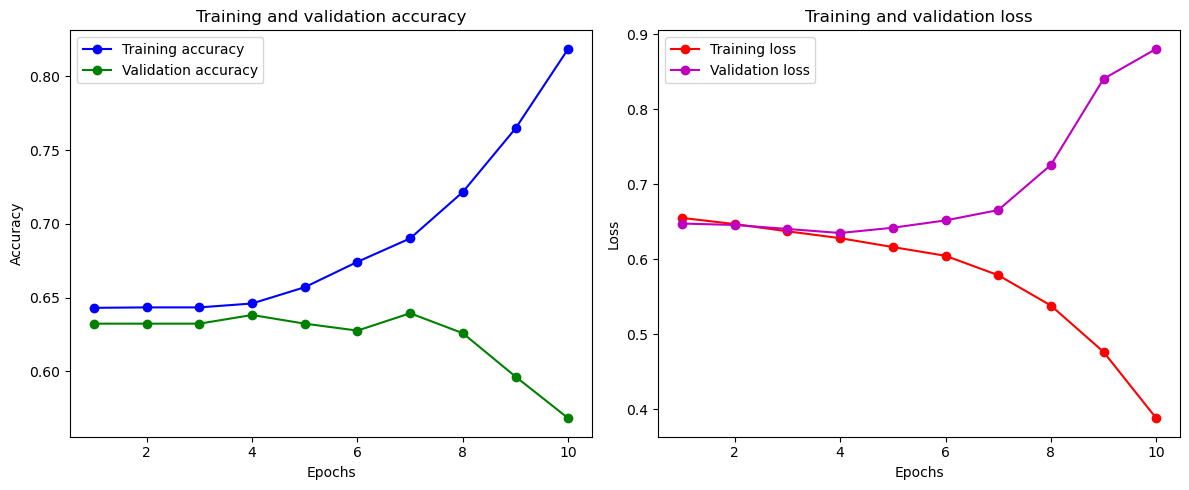

In [14]:
# Extracting the data from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'go-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro-', label='Training loss')
plt.plot(epochs, val_loss, 'mo-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model Evaluation

Finally, we evaluate the model on the test dataset and display metrics such as accuracy, precision, recall, F1 score, and the area under the ROC curve.

In [19]:
# Get predictions for the test data
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary classes

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
conf_matrix

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


array([[702, 373],
       [361, 264]], dtype=int64)

In [20]:
accuracy = accuracy_score(y_test,y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
AUC = roc_auc_score(y_test,y_pred_classes)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Area Under Curve:", AUC)

Accuracy: 0.5682352941176471
Precision: 0.41444270015698587
Recall: 0.4224
F1 Score: 0.41838351822503966
Area Under Curve: 0.5377116279069768


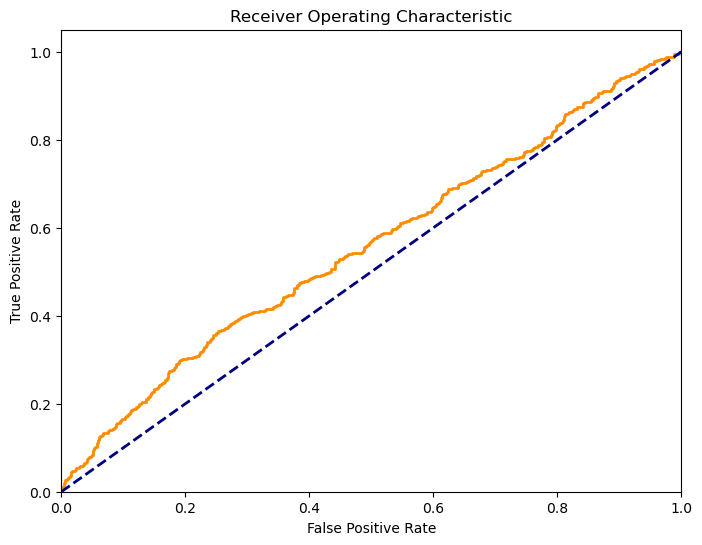

In [23]:
def plot_roc_curve(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.show()

# Call the function to plot the ROC curve
plot_roc_curve(y_test, y_pred)

## Conclusion and Analysis

### Model Performance Overview

Our Convolutional Neural Network (CNN) model was developed to detect hate speech in meme images and achieved a test accuracy of 56.82%. While the model demonstrates an ability to classify images, the performance metrics indicate substantial room for improvement:

- **Accuracy:** 56.82%
- **Precision:** 41.44%
- **Recall:** 42.24%
- **F1 Score:** 41.84%
- **Area Under Curve (AUC):** 53.77%

These results suggest that the model has limited capability in differentiating between hate speech and non-hate speech effectively, as reflected by the low values across all key metrics.

### Insights into Training Dynamics and Model Limitations

- **Training and Validation Trends:** The model showed an increasing training accuracy over the epochs, which reached up to 82.39% by the final epoch. However, the validation accuracy peaked at around 63.94% in the middle of the training process and then significantly dropped to 56.82% by the end of training, indicating possible overfitting to the training data.

- **Loss Trends:** Both training and validation loss decreased initially, with training loss continuing to decrease throughout the epochs. In contrast, validation loss started increasing after the fifth epoch, further supporting the notion of overfitting as the model became too tailored to the nuances of the training set and performed poorly on unseen data.

### Model Limitations and Data Handling Issues

- **Overfitting:** The disparity between training and validation accuracy and the increase in validation loss point to overfitting. The model's capacity might be too high relative to the complexity needed to understand the data, or the data might not be sufficient in volume or variety to train such a deep network without overfitting.

- **Generalization Capability:** The poor recall and precision suggest that the model struggles with generalizing its learning to new data. This could be due to the simplistic approach of resizing and normalizing images, which might not be adequate to capture the complex visual cues necessary for accurate hate speech detection.

- **Class Imbalance:** If the dataset has imbalanced classes, the model might be biased towards the majority class, leading to poorer performance metrics, particularly recall and F1 score.

### Recommendations for Future Improvements

- **Enhanced Image Preprocessing:** Implement more sophisticated image preprocessing techniques such as data augmentation (e.g., rotations, translations) to increase the diversity of training data and help the model generalize better.

- **Model Complexity Adjustment:** Consider simplifying the model or employing techniques like dropout or regularization more effectively to combat overfitting. Additionally, experimenting with different architectures or adding batch normalization might help in stabilizing the learning process.

- **Advanced Techniques for Imbalance:** Explore methods to handle class imbalance more effectively, such as weighted loss functions, oversampling the minority class, or using anomaly detection techniques for rare instances of hate speech.

- **Evaluation on Extended Dataset:** Evaluate the model on a more extensive and diverse dataset, or use cross-validation to assess its performance more reliably to ensure the model's robustness and reliability.